Вы успешно создали полноценную торговую стратегию на основе модели машинного обучения и обеспечили фиксацию и сравнение метрик полученных моделей.

Вы решаете построить более сложные модели машинного обучения и хотите использовать нейросетевые модели, в том числе для обработки временных рядов и глубокие нейронные сети. Здесь вам могут помочь методы рекуррентных сетей и современные трансформерные архитектуры.

Поговорив с коллегами, вы понимаете, что самостоятельно построить и обучить действительно сложные архитектуры будет сложно и решаете воспользоваться предобученными свободно распространяемыми моделями.

На основании вышесказанного вам необходимо построить несколько моделей на основе нейронных сетей, позволяющих прогнозировать оптимальное торговое действие.

На основе представленной информации, вам предлагается:

Создать модель (торговую стратегию) на основе нейронных сетей для прогнозирования оптимального торгового действия. Можно использовать, как самостоятельно обученные архитектуры, так и использовать предобученные сети или фреймворки.
Провести тестирование разработанной стратегии на валидационном датасете.
Зафиксировать метрики модели для дальнейшего сравнения экспериментов.
Сформировать дашборд, показывающий эффективность различных торговых
стратегий.

## Setup and Imports
Install required packages and import dependencies

In [1]:
%pip install backtesting nbformat matplotlib numpy pandas scikit-learn torch tqdm --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import traceback
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from assets.DataProvider import DataProvider
from assets.FeaturesGenerator import FeaturesGenerator
from assets.hw5.HybridStrategySMA_ML import HybridStrategySMA_ML
from assets.hw5.Models import StockCNN, StockCNN_LSTM, StockGRU, StockLSTM
from assets.hw5.SMABaselineGenerator import SMABaselineGenerator
from backtesting import Backtest, Strategy

c:\Users\Owner\anaconda3\envs\otus\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
g:\Work\Repos\otus_homework\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Helper Functions
Define utility functions for sequence creation, model training, and testing

In [3]:
def create_sequences(data_values, target_values, window_size):
    """Create sequences for time series data"""
    X, y = [], []
    for i in range(len(data_values) - window_size):
        X.append(data_values[i:(i + window_size)])
        y.append(target_values[i + window_size])
    return np.array(X), np.array(y)

In [4]:
def train_model(title, model, dataloader, num_epochs=10):
    """Train a PyTorch model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    model.eval()
    return model

In [5]:
def test_model(title, model, dataloader):
    """Test a trained model and calculate accuracy"""
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.numpy())
            all_targets.extend(targets.numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_targets, all_predictions)
    print(f"{title} Accuracy: {accuracy:.4f}")
    return accuracy
    # Plot actual vs predicted labels
    plt.figure(figsize=(12, 6))
    plt.plot(all_targets[-30:], label='Actual', color='blue', linestyle='--', alpha=0.7)
    plt.plot(all_predictions[-30:], label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Signal (0=Sell, 1=Hold, 2=Buy)")
    plt.legend()
    plt.show()
    
    return accuracy

## Main Trading Strategy Implementation

In [6]:
ticker = 'BTC/USDT'
timeframe = '1h'

# Initial parameters
strategy_best_params = {}
threshold = 0.2

In [7]:
# 1. Load the data
data_provider = DataProvider(tickers=[ticker], skip_dashboard=True)
if ticker not in data_provider.data:
    if not data_provider.data_load():
        data_provider.data_request()
        data_provider.data_save()
    data_provider.clean_data()
data = data_provider.data[ticker]

 Удалено 1 записей с высокой дисперсией для BTC/USDT
 Удалено 19 аномальных цен BTC/USDT
 Удалено 1 записей с высокой дисперсией для BTC/USDT
 Удалено 19 аномальных цен BTC/USDT


In [8]:
# 2. Generate features
features_generator = FeaturesGenerator()
data_initial_ohlc = data.copy()
feature_matrix, feature_names = features_generator.prepare_features(data_initial_ohlc)
num_features = feature_matrix.shape[1]
print(f"Number of features generated: {num_features} ({len(feature_names)} names)")

Number of features generated: 62 (62 names)


In [9]:
# 3. Generate target using SMA strategy
strategy_hw2 = SMABaselineGenerator(ticker, timeframe, data_provider)
strategy_best_results, strategy_best_params, strategy_trades = strategy_hw2.evaluate_strategies()

Running SMA strategy validation...
Testing 4 parameter combinations...


4it [00:00, 11.69it/s]


Best parameters found:
4.01: {'sma_short': 5, 'sma_long': 15, 'model': None}
3.86: {'sma_short': 8, 'sma_long': 20, 'model': None}
3.82: {'sma_short': 8, 'sma_long': 15, 'model': None}
3.12: {'sma_short': 5, 'sma_long': 20, 'model': None}

Best score: 4.01

Best strategy performance:
Return: 0.10%
Trades count: 112
Sharpe Ratio: 0.13
Max Drawdown: -0.44%
Win Rate: 38.39%


In [10]:
# 4. Prepare data for ML
data_extended = feature_matrix.copy()
if strategy_trades is None or strategy_trades.empty:
    print("WARN: No trades from SMA strategy. PnL and ReturnPct will be zero for y_base generation.")
    data_extended['PnL'] = 0.0
    data_extended['ReturnPct'] = 0.0
else:
    strategy_trades = strategy_trades.set_index('EntryTime')
    data_extended = data_extended.merge(strategy_trades[['PnL', 'ReturnPct']], 
                                        left_index=True, right_index=True, how='left')
    data_extended[['PnL', 'ReturnPct']] = data_extended[['PnL', 'ReturnPct']].fillna(value=0)

trades_return_pct = data_extended['ReturnPct'].values
y_base = [1 if x > threshold else 0 for x in trades_return_pct]

In [11]:
# 5. Create sequences for time series models
window_size = 30
X_np, y_np = create_sequences(feature_matrix.values, np.array(y_base), window_size)
print(f"Sequence shapes - X: {X_np.shape}, y: {y_np.shape}")

Sequence shapes - X: (2582, 30, 62), y: (2582,)


In [12]:
# 6. Prepare PyTorch datasets
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.long)
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
# 7. Initialize and train models
models = {
    'CNN': {'model': StockCNN(input_channels=num_features, window_size=window_size)},
    'LSTM': {'model': StockLSTM(input_size=num_features)},
    'GRU': {'model': StockGRU(input_size=num_features)},
    'CNN_LSTM': {'model': StockCNN_LSTM(input_channels=num_features)}
}

# Train and test each model
for model_key, model_dict in models.items():
    print(f"\nTraining {model_key}...")
    models[model_key]['model_trained'] = train_model(model_key, model_dict['model'], dataloader)
    models[model_key]['accuracy'] = test_model(model_key, model_dict['model_trained'], dataloader)


Training CNN...
Epoch [1/10], Loss: 0.1426
Epoch [2/10], Loss: 0.3085
Epoch [3/10], Loss: 0.1752
Epoch [4/10], Loss: 0.2035
Epoch [5/10], Loss: 0.2109
Epoch [6/10], Loss: 0.2153
Epoch [7/10], Loss: 0.1220
Epoch [8/10], Loss: 0.0602
Epoch [9/10], Loss: 0.1075
Epoch [10/10], Loss: 0.1630
CNN Accuracy: 0.9965

Training LSTM...
Epoch [1/10], Loss: 0.0031
Epoch [2/10], Loss: 0.0039
Epoch [3/10], Loss: 0.0045
Epoch [4/10], Loss: 0.0050
Epoch [5/10], Loss: 0.0038
Epoch [6/10], Loss: 0.0023
Epoch [7/10], Loss: 0.0023
Epoch [8/10], Loss: 0.0048
Epoch [9/10], Loss: 0.0028
Epoch [10/10], Loss: 0.0042
LSTM Accuracy: 0.9965

Training GRU...
Epoch [1/10], Loss: 0.0036
Epoch [2/10], Loss: 0.0041
Epoch [3/10], Loss: 0.0031
Epoch [4/10], Loss: 0.0020
Epoch [5/10], Loss: 0.0052
Epoch [6/10], Loss: 0.0062
Epoch [7/10], Loss: 0.0087
Epoch [8/10], Loss: 0.0023
Epoch [9/10], Loss: 0.0051
Epoch [10/10], Loss: 0.0024
GRU Accuracy: 0.9965

Training CNN_LSTM...
Epoch [1/10], Loss: 0.1685
Epoch [2/10], Loss: 0.

In [14]:
# 8. Backtest hybrid strategies
all_backtest_results = {}
for model_key, model_dict in models.items():
    print(f"\n\n\nPreparing backtest for model: {model_key}...")
    print(f"Running backtest for {model_key} using SMA logic (model not integrated yet).")
    bt = Backtest(data.copy(),  # Pass data.copy()
                    HybridStrategySMA_ML, 
                    cash=10000000, 
                    commission=.002)
    try:
        # Pass sma_short and sma_long to bt.run()
        stats = bt.run(
            sma_short=strategy_best_params['sma_short'],
            sma_long=strategy_best_params['sma_long'],
            model=models[model_key]['model_trained']
        )
        print(f"--- Backtest Results for {model_key} driven strategy ---")
        print(stats)
        all_backtest_results[model_key] = {'stats': stats}
        plot_path = "backtest_plots"
        os.makedirs(plot_path, exist_ok=True)
        plot_filename = os.path.join(plot_path, f"backtest_plot_{model_key}.html")
        try:
            bt.plot(filename=plot_filename, open_browser=False)
            all_backtest_results[model_key]['plot_file'] = plot_filename
            print(f"Backtest plot for {model_key} saved to {plot_filename}")
        except Exception as e:
            print(f"ERROR: Could not generate plot for {model_key}: {e}")
            all_backtest_results[model_key]['plot_file'] = None
            
    except Exception as e:
        print(f"ERROR during backtest for {model_key}: {e}")
        print("This might be due to HW2Strategy_SMA not being fully adapted for model-based trading,")
        print("or issues with data slicing/feature access within the strategy's next() method.")
        traceback.print_exc() # Print detailed traceback




Preparing backtest for model: CNN...
Running backtest for CNN using SMA logic (model not integrated yet).


INFO:bokeh.io.state:Session output file 'backtest_plots\backtest_plot_CNN.html' already exists, will be overwritten.


--- Backtest Results for CNN driven strategy ---
Start                     2017-08-27 00:00:00
End                       2025-05-07 00:00:00
Duration                   2810 days 00:00:00
Exposure Time [%]                    69.61935
Equity Final [$]               10049013.29762
Equity Peak [$]                 10070818.7374
Commissions [$]                   20603.31856
Return [%]                            0.49013
Buy & Hold Return [%]              2249.19632
Return (Ann.) [%]                     0.06351
Volatility (Ann.) [%]                 0.18088
CAGR [%]                              0.06353
Sharpe Ratio                           0.3511
Sortino Ratio                         0.51577
Calmar Ratio                          0.14505
Alpha [%]                            -2.71615
Beta                                  0.00143
Max. Drawdown [%]                    -0.43781
Avg. Drawdown [%]                    -0.05837
Max. Drawdown Duration     1097 days 00:00:00
Avg. Drawdown Duration       83

g:\Work\Repos\otus_homework\backtesting\_plotting.py:701: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

g:\Work\Repos\otus_homework\backtesting\_plotting.py:701: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



Backtest plot for CNN saved to backtest_plots\backtest_plot_CNN.html



Preparing backtest for model: LSTM...
Running backtest for LSTM using SMA logic (model not integrated yet).


INFO:bokeh.io.state:Session output file 'backtest_plots\backtest_plot_LSTM.html' already exists, will be overwritten.


--- Backtest Results for LSTM driven strategy ---
Start                     2017-08-27 00:00:00
End                       2025-05-07 00:00:00
Duration                   2810 days 00:00:00
Exposure Time [%]                    69.61935
Equity Final [$]               10049013.29762
Equity Peak [$]                 10070818.7374
Commissions [$]                   20603.31856
Return [%]                            0.49013
Buy & Hold Return [%]              2249.19632
Return (Ann.) [%]                     0.06351
Volatility (Ann.) [%]                 0.18088
CAGR [%]                              0.06353
Sharpe Ratio                           0.3511
Sortino Ratio                         0.51577
Calmar Ratio                          0.14505
Alpha [%]                            -2.71615
Beta                                  0.00143
Max. Drawdown [%]                    -0.43781
Avg. Drawdown [%]                    -0.05837
Max. Drawdown Duration     1097 days 00:00:00
Avg. Drawdown Duration       8

g:\Work\Repos\otus_homework\backtesting\_plotting.py:701: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

g:\Work\Repos\otus_homework\backtesting\_plotting.py:701: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



Backtest plot for LSTM saved to backtest_plots\backtest_plot_LSTM.html



Preparing backtest for model: GRU...
Running backtest for GRU using SMA logic (model not integrated yet).


INFO:bokeh.io.state:Session output file 'backtest_plots\backtest_plot_GRU.html' already exists, will be overwritten.


--- Backtest Results for GRU driven strategy ---
Start                     2017-08-27 00:00:00
End                       2025-05-07 00:00:00
Duration                   2810 days 00:00:00
Exposure Time [%]                    69.61935
Equity Final [$]               10049013.29762
Equity Peak [$]                 10070818.7374
Commissions [$]                   20603.31856
Return [%]                            0.49013
Buy & Hold Return [%]              2249.19632
Return (Ann.) [%]                     0.06351
Volatility (Ann.) [%]                 0.18088
CAGR [%]                              0.06353
Sharpe Ratio                           0.3511
Sortino Ratio                         0.51577
Calmar Ratio                          0.14505
Alpha [%]                            -2.71615
Beta                                  0.00143
Max. Drawdown [%]                    -0.43781
Avg. Drawdown [%]                    -0.05837
Max. Drawdown Duration     1097 days 00:00:00
Avg. Drawdown Duration       83

g:\Work\Repos\otus_homework\backtesting\_plotting.py:701: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

g:\Work\Repos\otus_homework\backtesting\_plotting.py:701: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



Backtest plot for GRU saved to backtest_plots\backtest_plot_GRU.html



Preparing backtest for model: CNN_LSTM...
Running backtest for CNN_LSTM using SMA logic (model not integrated yet).


INFO:bokeh.io.state:Session output file 'backtest_plots\backtest_plot_CNN_LSTM.html' already exists, will be overwritten.


--- Backtest Results for CNN_LSTM driven strategy ---
Start                     2017-08-27 00:00:00
End                       2025-05-07 00:00:00
Duration                   2810 days 00:00:00
Exposure Time [%]                    69.61935
Equity Final [$]               10049013.29762
Equity Peak [$]                 10070818.7374
Commissions [$]                   20603.31856
Return [%]                            0.49013
Buy & Hold Return [%]              2249.19632
Return (Ann.) [%]                     0.06351
Volatility (Ann.) [%]                 0.18088
CAGR [%]                              0.06353
Sharpe Ratio                           0.3511
Sortino Ratio                         0.51577
Calmar Ratio                          0.14505
Alpha [%]                            -2.71615
Beta                                  0.00143
Max. Drawdown [%]                    -0.43781
Avg. Drawdown [%]                    -0.05837
Max. Drawdown Duration     1097 days 00:00:00
Avg. Drawdown Duration    

g:\Work\Repos\otus_homework\backtesting\_plotting.py:701: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

g:\Work\Repos\otus_homework\backtesting\_plotting.py:701: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



In [15]:
# Print summary
print("\n\n--- Summary of All Backtest Results ---")

print("\n\n--- Original strategy stats ---")
print(strategy_best_results)

for model_key, strategy_results in all_backtest_results.items():
    print(f"\n--- Results for {model_key} ---")
    print(strategy_results['stats'])
    if 'plot_file' in strategy_results and strategy_results['plot_file']:
        print(f"Plot saved to: {strategy_results['plot_file']}")
    else:
        print("Plot generation failed or was not attempted.")



--- Summary of All Backtest Results ---


--- Original strategy stats ---
Start                     2017-08-27 00:00:00
End                       2023-01-14 00:00:00
Duration                   1966 days 00:00:00
Exposure Time [%]                    66.19217
Equity Final [$]               10010177.57918
Equity Peak [$]                10049764.30264
Commissions [$]                    8977.05936
Return [%]                            0.10178
Buy & Hold Return [%]                407.3376
Return (Ann.) [%]                     0.01888
Volatility (Ann.) [%]                 0.14521
CAGR [%]                              0.01889
Sharpe Ratio                             0.13
Sortino Ratio                         0.18305
Calmar Ratio                          0.04312
Alpha [%]                            -0.31913
Beta                                  0.00103
Max. Drawdown [%]                    -0.43781
Avg. Drawdown [%]                    -0.04807
Max. Drawdown Duration     1097 days 00:00:00
Avg.

C:\Users\Owner\AppData\Local\Temp\ipykernel_25340\752815044.py:36: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Owner\AppData\Local\Temp\ipykernel_25340\752815044.py:36: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Owner\AppData\Local\Temp\ipykernel_25340\752815044.py:36: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\Owner\AppData\Local\Temp\ipykernel_25340\752815044.py:36: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



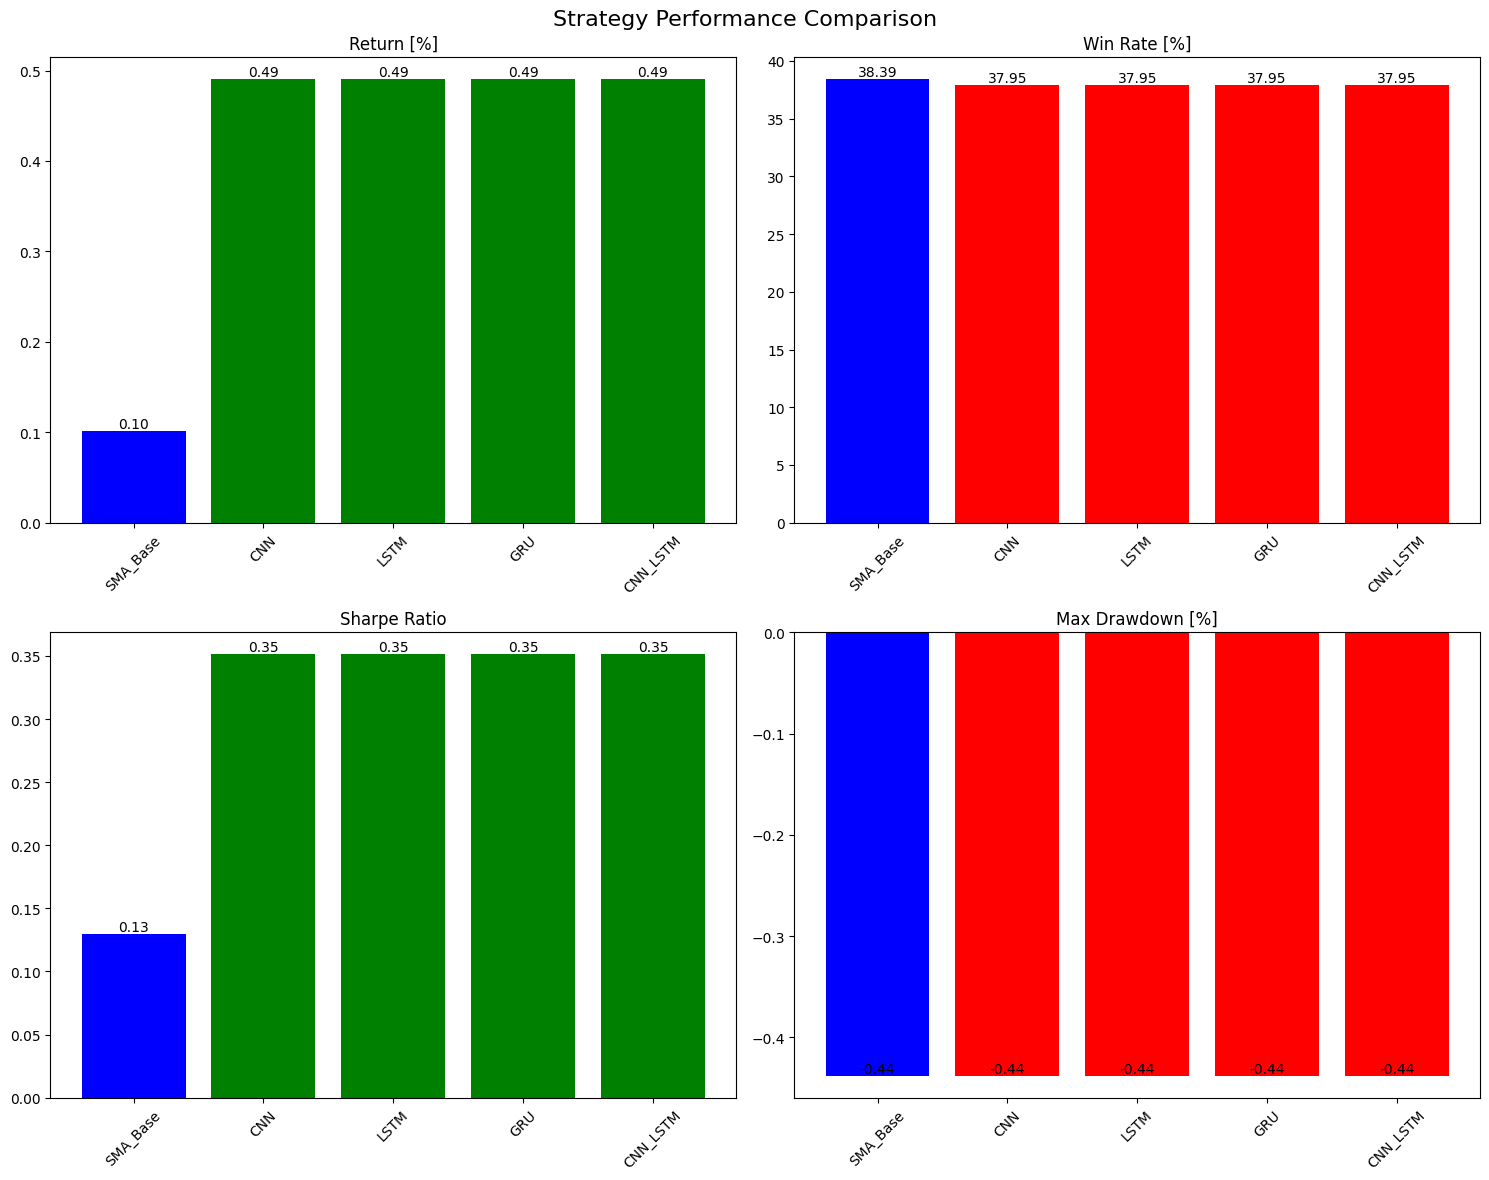

,Return [%],Win Rate [%],Sharpe Ratio,Max Drawdown [%]
SMA_Base,0.101776,38.392857,0.130003,-0.437814
CNN,0.490133,37.951807,0.351105,-0.437814
LSTM,0.490133,37.951807,0.351105,-0.437814
GRU,0.490133,37.951807,0.351105,-0.437814
CNN_LSTM,0.490133,37.951807,0.351105,-0.437814


In [16]:
def plot_strategy_comparisons(strategy_best_results, all_backtest_results):
    # Extract key metrics for comparison
    metrics = {
        'Return [%]': [],
        'Win Rate [%]': [],
        'Sharpe Ratio': [],
        'Max Drawdown [%]': []
    }
    strategy_names = ['SMA_Base'] + list(all_backtest_results.keys())
    
    # Add baseline SMA results
    metrics['Return [%]'].append(strategy_best_results['Return [%]'])
    metrics['Win Rate [%]'].append(strategy_best_results['Win Rate [%]'])
    metrics['Sharpe Ratio'].append(strategy_best_results['Sharpe Ratio'])
    metrics['Max Drawdown [%]'].append(strategy_best_results['Max. Drawdown [%]'])
    
    # Add hybrid strategy results
    for model_key in all_backtest_results.keys():
        stats = all_backtest_results[model_key]['stats']
        metrics['Return [%]'].append(stats['Return [%]'])
        metrics['Win Rate [%]'].append(stats['Win Rate [%]'])
        metrics['Sharpe Ratio'].append(stats['Sharpe Ratio'])
        metrics['Max Drawdown [%]'].append(stats['Max. Drawdown [%]'])
    
    # Create subplots for each metric
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Strategy Performance Comparison', fontsize=16)
    
    for (metric, values), ax in zip(metrics.items(), axes.flat):
        colors = ['blue'] + ['green' if v > values[0] else 'red' for v in values[1:]]
        if metric in ['Max Drawdown [%]']:  # Inverse colors for metrics where lower is better
            colors = ['blue'] + ['green' if v < values[0] else 'red' for v in values[1:]]
            
        bars = ax.bar(strategy_names, values, color=colors)
        ax.set_title(metric)
        ax.set_xticklabels(strategy_names, rotation=45)
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Create a summary table
    summary_df = pd.DataFrame(metrics, index=strategy_names)
    display(summary_df)

# Plot the comparisons
plot_strategy_comparisons(strategy_best_results, all_backtest_results)